## Use Generative AI in Images Solution

## Install Library

In [18]:
%pip install openai
%pip install requests
%pip install pillow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Load Azure Configuration

In [19]:
import os

azure_openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_openai_key = os.getenv("AZURE_OPENAI_API_KEY")
azure_openai_api_version = os.getenv("AZURE_OPENAI_API_VERSION")

azure_computer_vision_endpoint = os.environ["AZURE_COMPUTER_VISION_ENDPOINT"]
azure_computer_vision_key = os.environ["AZURE_COMPUTER_VISION_KEY"]

## Create Clients

In [20]:
from openai import AsyncAzureOpenAI

# AzureOpenAI is the standard client for interacting with Azure's OpenAI Service, but it does not support asynchronous operations
# AsyncAzureOpenAI is designed to support asynchronous operations, allowing your code to perform other tasks while waiting for the API response
dalle_client = AsyncAzureOpenAI(
    api_key=azure_openai_key, 
    api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint
)
deployment_name = "dall-e-3"

# Create the Vision client
vision_client = AsyncAzureOpenAI(
    api_key=azure_openai_key, 
    api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint
)
vision_deployment_name = "gpt-4o"

## Generate, Show and Save the Images

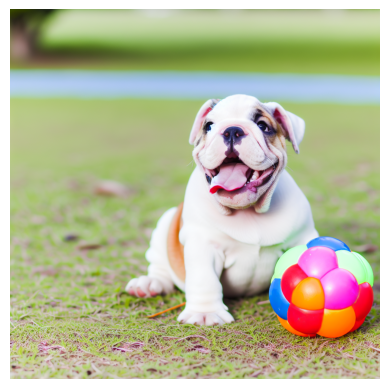

In [21]:
from PIL import Image
import requests
import matplotlib.pyplot as plt

user_prompt = """Create an image of a playful bulldog puppy sitting in a grassy park, with a colorful ball next to it. 
The bulldog should have a happy expression and its tongue sticking out."""

# generate an image using the DALL-E 3 model
result = await dalle_client.images.generate(
    model=deployment_name, # the name of your DALL-E 3 deployment
    prompt=user_prompt,
    size="1024x1024", 
    style="natural",
    quality="standard",
    n=1
)

# Retrieve the image URL from the response (assuming response structure)
image_url = result.data[0].url

# Open the image from the URL
im = Image.open(requests.get(image_url, stream=True).raw)

# Save the image to a file
im.save("images/dog1.jpg")

# Display the image with matplotlib
plt.imshow(im)
plt.axis("off")  # Turn off axis labels
plt.show()

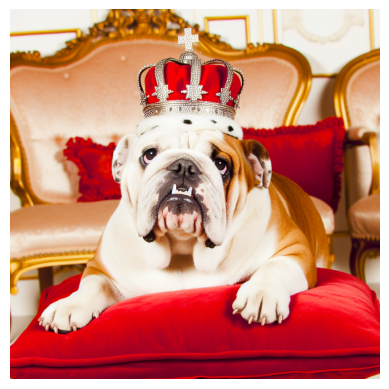

In [22]:
from PIL import Image
import requests
import matplotlib.pyplot as plt

user_prompt = """Generate an image of a regal-looking adult bulldog wearing a small crown, sitting on a red velvet cushion. 
The background should be a luxurious room with elegant decor."""

# generate an image using the DALL-E 3 model
result = await dalle_client.images.generate(
    model=deployment_name, # the name of your DALL-E 3 deployment
    prompt=user_prompt,
    size="1024x1024", 
    style="natural",
    quality="standard",
    n=1
)

# Retrieve the image URL from the response (assuming response structure)
image_url = result.data[0].url

# Open the image from the URL
im = Image.open(requests.get(image_url, stream=True).raw)

# Save the image to a file
im.save("images/dog2.jpg")

# Display the image with matplotlib
plt.imshow(im)
plt.axis("off")  # Turn off axis labels
plt.show()

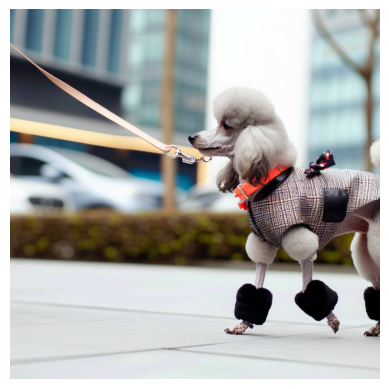

In [23]:
from PIL import Image
import requests
import matplotlib.pyplot as plt

user_prompt = """Create an image of a poodle dressed in a cute outfit, walking down a city street with a leash in its mouth."""

# generate an image using the DALL-E 3 model
result = await dalle_client.images.generate(
    model=deployment_name, # the name of your DALL-E 3 deployment
    prompt=user_prompt,
    size="1024x1024", 
    style="natural",
    quality="standard",
    n=1
)

# Retrieve the image URL from the response (assuming response structure)
image_url = result.data[0].url

# Open the image from the URL
im = Image.open(requests.get(image_url, stream=True).raw)

# Save the image to a file
im.save("images/dog3.jpg")

# Display the image with matplotlib
plt.imshow(im)
plt.axis("off")  # Turn off axis labels
plt.show()

## Get the Image and Analyze it

In [24]:
import base64
from pathlib import Path

# Create a Path object for the image file
image_path = Path("images/dog1.jpg")

# Using a context manager to open the file with Path.open()
with image_path.open("rb") as image_file:
    base64_image = base64.b64encode(image_file.read()).decode("utf-8")

# Prepare the image content in the required format for the Azure OpenAI service
content_images = [
    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
    for base64_image in [base64_image]
]

# Define the user prompt for the image description
user_prompt = "Describe this image in detail."

# Send a request to the Azure OpenAI service to analyze the image and generate a description
response = await vision_client.chat.completions.create(
    model=vision_deployment_name,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": user_prompt,
                },
                *content_images,  # Include the image content in the request
            ],
        }
    ],
    max_tokens=1000,  # Set the maximum number of tokens for the response
)

# Print the generated description of the image
print("Response: " + response.choices[0].message.content)

Response: The image features an adorable Bulldog puppy sitting on green grass in an outdoor setting. The puppy has a short, stocky body with a wrinkled face and a white fur coat accented by light brown patches. Its tongue is hanging out as it appears to be smiling in a playful and happy demeanor. Next to the puppy is a vibrant, colorful ball composed of interconnected, soft sections in bright shades of blue, pink, orange, green, and red. The background reveals a blurred landscape of grass with a pathway and trees, evocative of a park or garden setting. The lighting is bright and natural, suggesting a sunny day. The overall mood of the image is cheerful and lively, highlighting the playful energy of the puppy.


## Calculate Vector Similarity

In [25]:
import numpy as np

def cosine_similarity(vector1, vector2):
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

## Vectorize Image API

In [26]:
import requests

# Function to vectorize an image
def vectorize_image(image_source, is_url=True):
    # API URL
    url = f"{azure_computer_vision_endpoint}/computervision/retrieval:vectorizeImage?api-version=2024-02-01&model-version=2023-04-15"

    headers = {
        "Ocp-Apim-Subscription-Key": azure_computer_vision_key
    }

    try:
        if is_url:
            # Set headers for URL
            headers["Content-Type"] = "application/json"
            data = {
                "url": image_source
            }
            # Make the request
            response = requests.post(url, headers=headers, json=data)
        else:
            # Read the image file
            with open(image_source, "rb") as image_file:
                image_data = image_file.read()

            # Set headers for image file
            headers["Content-Type"] = "application/octet-stream"
            # Make the request
            response = requests.post(url, headers=headers, data=image_data)

        response.raise_for_status()  # Raise an exception for HTTP errors

        # Return the response
        return response.json()

    except requests.exceptions.RequestException as e:
        print(f"Error: {e}")
        return None

## Calculate Image Embeddings

In [27]:
dog1_result = vectorize_image("images/dog1.jpg", False)
print("Dog 1: ", dog1_result["vector"])

dog2_result = vectorize_image("images/dog2.jpg", False)
print("Dog 2: ", dog1_result["vector"])

dog3_result = vectorize_image("images/dog3.jpg", False)
print("Dog 3: ", dog1_result["vector"])


Dog 1:  [1.3369141, -0.123168945, -1.2128906, 0.97265625, -0.71191406, -0.09875488, 1.1210938, -0.04434204, -0.97558594, 2.1328125, 0.3269043, 1.9414062, 1.8007812, -0.65234375, -0.21813965, -1.0888672, 3.2324219, -2.5546875, 0.8461914, 0.23730469, 0.050048828, -1.9316406, 1.2392578, 1.9462891, -1.5869141, 0.17175293, -50.75, 0.2310791, -0.4189453, 0.51708984, 0.09576416, 0.5175781, 0.038269043, -0.39672852, 0.7890625, -0.96484375, 0.15283203, 0.1920166, 0.39013672, -2.2402344, 1.6347656, 0.6616211, -2.2949219, 0.20739746, -2.0195312, -0.11401367, -2.3378906, -0.6147461, 1.4267578, 0.6870117, -1.4277344, -0.92871094, -0.85009766, 0.36572266, 1.5410156, -0.4790039, 0.69433594, -1.7333984, 1.34375, 0.6479492, 1.1523438, 0.5239258, 0.65283203, 0.21923828, 2.2910156, -1.3447266, -0.5595703, 0.828125, 1.2695312, 0.10699463, -0.8300781, -1.9824219, 0.039367676, -2.1582031, 1.4267578, -1.8183594, -2.6386719, -1.4794922, -1.0722656, -2.0546875, 1.2363281, 0.79541016, 2.1582031, -0.4284668, 0.4

## Calculate Image Similarity

In [28]:
print("Dog 1 Bulldog vs Dog 2 Bulldog")
print(cosine_similarity(dog1_result["vector"], dog2_result["vector"]))

print("Dog 1 Bulldog vs Dog 3 Poodle")
print(cosine_similarity(dog1_result["vector"], dog3_result["vector"]))

print("Dog 2 Bulldog vs Dog 3 Poodle")
print(cosine_similarity(dog2_result["vector"], dog3_result["vector"]))

# Dog 1 and Dog 2 are more similar than Dog 1 and Dog 3 or Dog 2 and Dog 3

Dog 1 Bulldog vs Dog 2 Bulldog
0.8288886024623785
Dog 1 Bulldog vs Dog 3 Poodle
0.727460570045139
Dog 2 Bulldog vs Dog 3 Poodle
0.7026013428968648


## Vectorize Text API

In [29]:
import requests

def vectorize_text(text):
    
    # API URL
    url = f"{azure_computer_vision_endpoint}/computervision/retrieval:vectorizeText?api-version=2024-02-01&model-version=2023-04-15"

    # Set headers
    headers = {
        "Content-Type": "application/json",
        "Ocp-Apim-Subscription-Key": azure_computer_vision_key
    }

    # Set the data payload
    data = {
        "text": text
    }

    try:
        # Make the request
        response = requests.post(url, headers=headers, json=data)
        response.raise_for_status()  # Raise an exception for HTTP errors

        # Return the JSON response
        return response.json()

    except requests.exceptions.RequestException as e:
        print(f"Error: {e}")
        return None


## Calculate Text Embedding

In [30]:
user_input = "bulldog"
text_bulldog_vector = vectorize_text(user_input)
print("Bulldog: ", text_bulldog_vector["vector"])

user_input = "poodle"
text_poodle_vector = vectorize_text(user_input)
print("Poodle: ", text_poodle_vector["vector"])


Bulldog:  [0.003206253, -0.004096985, -0.011413574, -0.004447937, 0.0007596016, 0.01285553, 0.014839172, 0.0020809174, 0.00051784515, 0.0011692047, -0.000770092, 0.012084961, 0.027236938, 0.0018672943, 0.00044608116, -0.006061554, -0.008049011, -0.025619507, -0.008399963, -0.0037994385, 0.0075645447, -0.009788513, -0.02671814, 0.014579773, 0.002910614, 0.0042877197, -0.2932129, 0.0065956116, 0.0035629272, 0.014770508, -0.0011930466, 0.009941101, -0.0039596558, 0.0032520294, 0.01260376, -0.0178833, -0.0023288727, 0.0053215027, 0.004634857, -0.013832092, -0.01625061, 0.002576828, -0.011711121, 0.006164551, -0.027740479, 0.014579773, -0.021911621, 0.008903503, -0.0077171326, 0.013877869, 0.00062799454, -0.005050659, 0.0041007996, -0.005836487, 0.005844116, 0.00057411194, 0.032592773, 0.002866745, 0.001241684, 0.022277832, -0.011917114, 0.0002810955, 0.005760193, 0.007686615, 0.009544373, -0.013519287, 0.0020942688, -0.018600464, -0.011482239, -0.007896423, -0.009666443, 0.014945984, -0.00

## Calculate Similarity between Text Input and Images

In [31]:
print("Bulldog Text vs Images")
print(cosine_similarity(text_bulldog_vector["vector"], dog1_result["vector"]))
print(cosine_similarity(text_bulldog_vector["vector"], dog2_result["vector"]))
print(cosine_similarity(text_bulldog_vector["vector"], dog3_result["vector"]))

print("Poodle Text vs Images")
print(cosine_similarity(text_poodle_vector["vector"], dog1_result["vector"]))
print(cosine_similarity(text_poodle_vector["vector"], dog2_result["vector"]))
print(cosine_similarity(text_poodle_vector["vector"], dog3_result["vector"]))

# Bulldog text is more similar to the first and second image vs the third image
# Poodle text is more similar to the third image vs the first and second image

Bulldog Text vs Images
0.3841816456613038
0.3850304454556468
0.3181363768989825
Poodle Text vs Images
0.3280728811516073
0.32349882414851944
0.38577110429413325
